In [1]:
import numpy as np
from scipy.special import binom
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
V = 9
q = 3

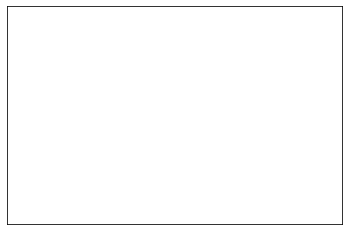

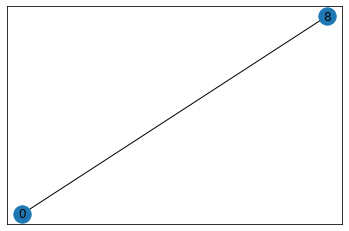

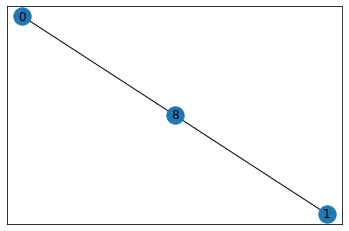

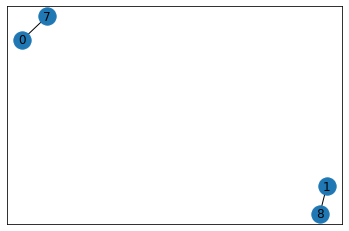

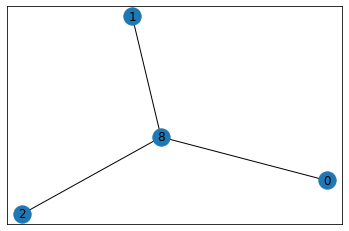

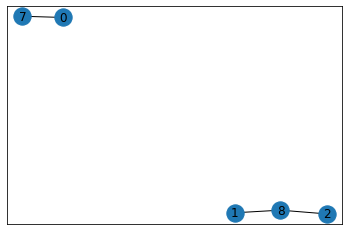

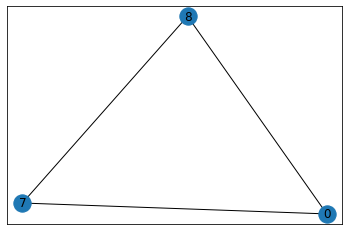

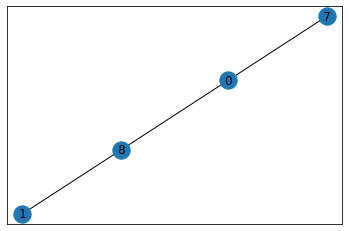

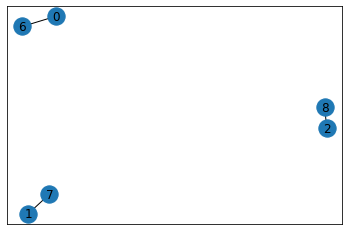

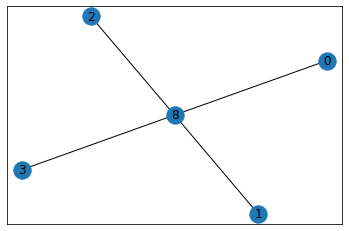

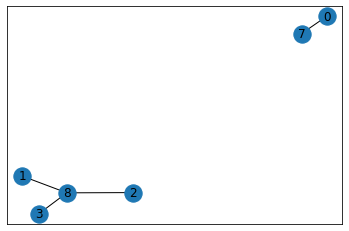

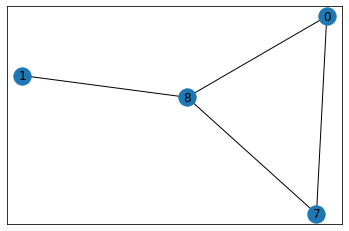

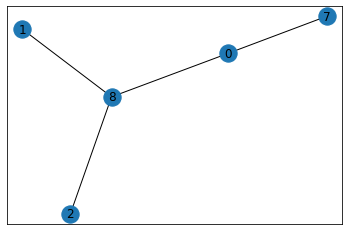

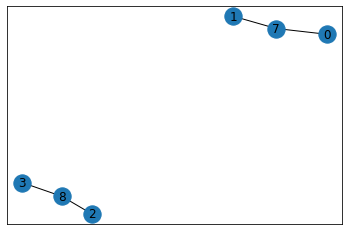

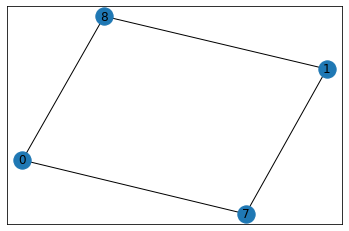

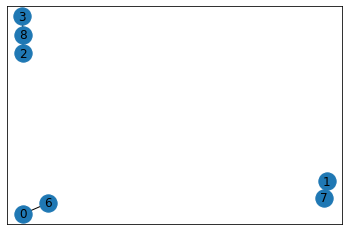

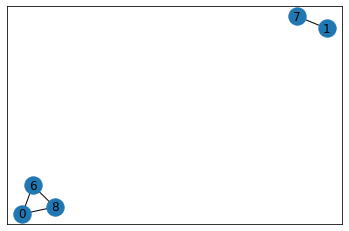

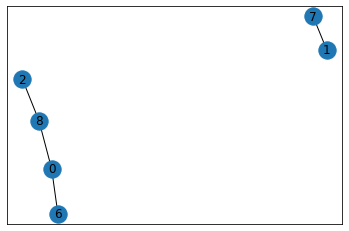

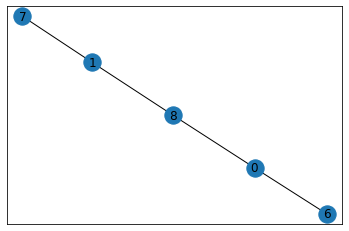

In [7]:
ALLGRAPHS = sorted(nx.read_graph6("graph9.g6"), key = lambda G: G.number_of_edges())
for g in ALLGRAPHS[:19]:
    GraphVisualization(g).visualize()

In [3]:
# helper functions

class GraphVisualization:
    """
    GraphVisualization(G).visualize() to visualize a graph
    """
    
    def __init__(self, g = None):
        self.visual = [] if g == None else list(g.edges()) # the set of edges of a graph
          
    def addEdge(self, a, b):
        # add edge to the edge list
        temp = [a, b]
        self.visual.append(temp)
          
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
        

# def plot_edges(edge_list):
#     G = GraphVisualization()
#     for edge in edge_list:
#         G.addEdge(edge[0], edge[1])
#     G.visualize()
      

def edge_list(g):
    """
    return the graph in adjacency list format 
    helper function for CutGraph.__init__()
    """
    graph = defaultdict(list)
    for u,v in list(g.edges()):
        graph[u].append(v)
        graph[v].append(u)
    return graph

def clean_graph(H):
    """
    remove all isolated vertices
    """
    toRemove = []
    for v in H.nodes():
        if H.degree(v) < 1:
            toRemove += [v]
    if len(toRemove) > 0:
        H.remove_nodes_from(toRemove)
        
# This class represents an undirected graph
# using adjacency list representation
class CutGraph:
    def __init__(self, g = None):
        self.V = 0 if (g == None or len(list(g.nodes())) == 0) else max(list(g.nodes()))+1 # No. of vertices
        self.g = g
        self.graph = defaultdict(list) if g == None else edge_list(g) # default dictionary to store graph
        self.Time = 0
  
    # function to add an edge to graph
    def addEdge(self, u, v):
        self.graph[u].append(v)
        self.graph[v].append(u)        
    def APUtil(self, u, visited, ap, parent, low, disc):
 
        children = 0
        visited[u]= True
        disc[u] = self.Time
        low[u] = self.Time
        self.Time += 1
        for v in self.graph[u]:
            if visited[v] == False :
                parent[v] = u
                children += 1
                self.APUtil(v, visited, ap, parent, low, disc)
                low[u] = min(low[u], low[v])
                if parent[u] == -1 and children > 1:
                    ap[u] = True
                if parent[u] != -1 and low[v] >= disc[u]:
                    ap[u] = True   
            elif v != parent[u]:
                low[u] = min(low[u], disc[v])
 
 
    # The function to do DFS traversal. It uses recursive APUtil()
    def find_cut(self):
        visited = defaultdict(lambda: False) # visited vertices
        disc = defaultdict(lambda: float("inf")) # discovery time
        low = defaultdict(lambda: float("inf")) # lowest vertex recheable
        parent = defaultdict(lambda: -1) # parent dictionary
        ap = defaultdict(lambda: False) # To store articulation points
 
        for i in range(self.V):
            if visited[i] == False:
                self.APUtil(i, visited, ap, parent, low, disc)
        for v, value in ap.items():
            if value == True: 
                yield v
                
    def cut(self):
        """
        returns the seperation of blocks
        """
        output = self.g.copy()
        cut_vertices = list(self.find_cut())
        output.remove_nodes_from(cut_vertices)
        cc = list(nx.connected_components(output))
        max_vertex = self.V
        for cut in cut_vertices:
            for component in cc:
                for v in component:
                    if cut in self.graph[v]: output.add_edge(max_vertex,v)
                max_vertex += 1
        clean_graph(output)
        return output

In [4]:
def find_class(g_data, iso_classes):
    for i, class_data in enumerate(iso_classes):
        if nx.is_isomorphic(g_data[0], class_data[0]) and g_data[1] == class_data[1]:
            return i
    return -1

def same_class(g, class_data):
    g_data = pruneEdges(g.copy())
    return nx.is_isomorphic(g_data[0], class_data[0]) and g_data[1] == class_data[1]

def count_nodes(g):
    counter = 0
    for v in g.nodes():
        if g.degree(v)>0:
            counter+=1
    return counter

#Prunes all edges not part of any cycle
def pruneEdges(H):
    #print ("Pruning", H.edges())
    m = len(H.edges())

    while True:
        toRemove = []
        for v in H.nodes():
            if H.degree(v) <= 1:
                toRemove += [v]
        if len(toRemove) > 0:
            H.remove_nodes_from(toRemove)
        else:
#             #combine all connected components
#             comps = (list)(nx.connected_components(H))
#             if len(comps) > 1:
#                 u = min(comps[0])
#                 for comp in comps[1:]:
#                     H = nx.contracted_nodes(H, u, min(comp))
            #print ("Pruned to ", H.edges())
            cc = CutGraph(H).cut()
            return (cc, m - len(H.edges()), count_nodes(cc) + (m - len(H.edges()))*2)


def pruned_atlas(size):
    atlas = sorted(nx.graph_atlas_g()[1:], key = lambda G: G.number_of_edges())
    iso_classes = []
    unpruned_list = []

    for G in atlas:
        #reduce to "isomorphism class" of matroid
        data = pruneEdges(G.copy())

        #if already in list, continue
        if find_class(data, iso_classes) != -1:
            continue

        #add this to the list of classes found    
        iso_classes += [data]
        unpruned_list += [G]

        if len(iso_classes) >= size:
            break
#     return unpruned_list
    return iso_classes

In [5]:
def all_colorings(V, q=3):
    for i in range(q**V):
        b = bin(i)[2:]
        yield str(0) * (V - len(b)) + b

def prume(G, C):
    # remove monochromatic edge
    g = G.copy()
    for e in g.edges():
        if C[e[0]]==C[e[1]]: 
            g.remove_edge(e[0],e[1])
    
    # remove isolated vertex
    g.remove_nodes_from(list(nx.isolates(g)))
    return g

def count_iso_colorings(G, V, B):
    return np.count_nonzero(np.array([same_class(prume(G, C), B) for C in all_colorings(V, q)]))

def DC(x, q = 2, V = 9):
    """
    return the value of DC given x, q and V
    """
    return max([comb(n,V)/(q**(n-V)*comb(n-x,V-x)) for n in range(V+1,max(2*x+1,V+2))])

In [ ]:
ISO_COUNT = np.array([[count_iso_colorings(g, V, B) for B in pruned_atlas(40)] for g in ALLGRAPHS])/q**V
print(ISO_COUNT.sum(axis = 1))

In [ ]:
DCs = np.array([DC(nodes(g), V = V) for g in ALL9BIPARTITE])

In [93]:
def check_condition_2(coefs):
    """
    check that all graphs with at most 3 edges have mu less than or equal to 1
    """
    sums = np.apply_along_axis(lambda x: np.sum(x*coefs), 1, ISO_COUNT[:9])
    print(np.max(np.abs(sums)[1:]))
    return all(np.abs(sums)[1:] <=1) and sums[0] == 7

def check_condition_3(coefs):
    """
    check that all graphs with more than tC2 edges and at most V vertices have mu at most 1-delta
    check that the maximum bound is at most 1-delta by iterating over all graphs on at most V certices
    """
    small_sums = np.apply_along_axis(lambda x: np.sum(x*coefs), 1, ISO_COUNT[9:]) # graphs > tC2 edges and <= V vertices
    large_sums = np.apply_along_axis(lambda x: np.sum(x*abs(coefs)*DCs), 1, ISO_COUNT[1:]) # check graphs > tC2 edges and > V vertices
#     return (np.max(large_sums/q**(ALLCC[1:]-1)) <= 1 - delta) and all(np.abs(small_sums) <= 1 - delta)
    print(np.max(large_sums/q**(ALLCC[1:]-1)), np.max(np.abs(small_sums)))
    

In [87]:
def create_nx_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

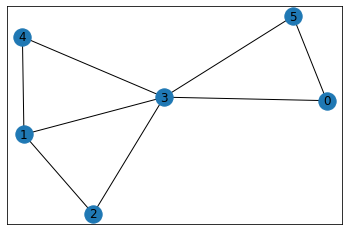

3 

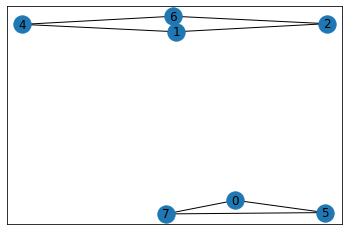

In [88]:
target = create_nx_graph([[1,2],[1,3],[1,4],[2,3],[3,4],[3,5],[3,0],[5,0]])
GraphVisualization(target).visualize()
blocks = CutGraph(target).cut()
GraphVisualization(blocks).visualize()

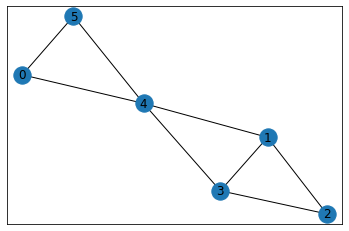

4 

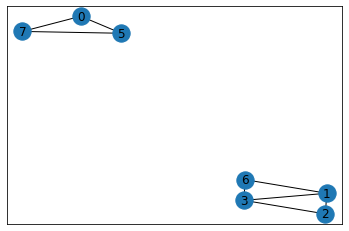

In [89]:
target2 = create_nx_graph([[1,2],[1,3],[1,4],[2,3],[3,4],[4,5],[4,0],[5,0]])
GraphVisualization(target2).visualize()
blocks2 = CutGraph(target2).cut()
GraphVisualization(blocks2).visualize()

In [90]:
nx.is_isomorphic(blocks, blocks2)

True

In [136]:
print([G[2] for G in pruned_atlas(40)])

[0, 2, 4, 3, 6, 5, 4, 8, 4, 7, 6, 5, 10, 4, 6, 6, 5, 5, 9, 8, 7, 6, 12, 6, 5, 5, 5, 8, 8, 7, 7, 7, 6, 6, 6, 11, 10, 9, 8, 7]


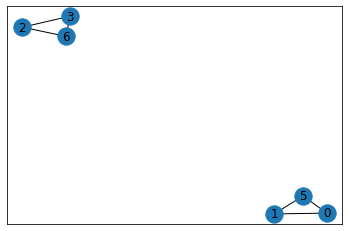

no. lines 0 claimed no. nodes 7 calc no. of nodes 6


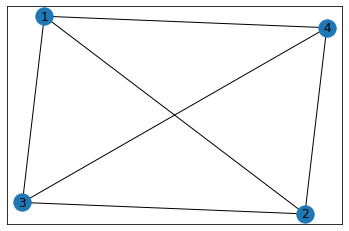

no. lines 1 claimed no. nodes 8 calc no. of nodes 6


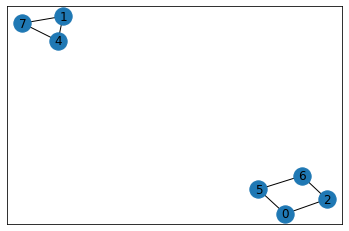

no. lines 0 claimed no. nodes 8 calc no. of nodes 7


In [137]:
# print ("First 10 equivalence classes: ")
verts = [0, 2, 4, 3, 6, 5, 4, 8, 4, 7, 6, 5, 10, 4, 6, 7, 5, 5, 9, 8, 7, 6, 12, 8, 5, 5, 5, 8, 8, 7, 7, 8, 6, 6, 6]
for G,v in zip(pruned_atlas(40), verts):
    if v != G[2]:
        GraphVisualization(G[0]).visualize()
        print("no. lines", G[1], "claimed no. nodes", v, "calc no. of nodes", G[2])

# for i, G in enumerate(pruned_atlas(70)[40:]):
#     if nx.is_isomorphic(G, target):
#         print("found", i+40)
#         GraphVisualization(G).visualize()
#         GraphVisualization(target).visualize()
#     elif nx.is_isomorphic(G, target2):
#         print("found", i+40)
#         GraphVisualization(G).visualize()
#         GraphVisualization(target2).visualize()


# # index_in_atlas can be used to find the index of a graph
# atl = pruned_atlas(100)
# ind = index_in_atlas(atl, nx.complete_graph(4))
# print ("K_4 has index ", ind, "and edges ", atl[ind].edges())
# print ()

# #This is the list of coefficients, indexed in the same order that pruned_atlas outputs.
# COEFFS = [63.0, -30.0, 12.0, -63.0, 0.0, 6.0, -39.0, -1.926, 12.0, 5.478, 4.293, -16.5, 0.0, 0.0, 0.0, 0.0, -20.3, 24.75, 0.0, -2.274, 2, -11.528, 0.0, 0.0, -22.928, -12.8, 0.0, 0.0, 0.0, -1.2, -4.362, 0.0, 1.138, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# len(COEFFS)

# #integer values
# COEFFS_INT = [int(1000 * x) for x in COEFFS]

# # For each graph G on 9 vertices and unlabeled H we need to know #{phi in [q]^{V(G)}: G_phi \cong H}
# # This is pre-computed and stored in subg_counts_9.npy


# # Checks prop 2.5 for graphs up to 9 vtx. 
# # Computes 1000 * (3^9) * mu(G).
# print ("Checking mu for graphs up to 9 vertices...")
# check_with_coeffs(COEFFS_INT)
# print()

# # Computes the maximum in Prop 3.5, multiplied by 324000 * (3^9) for integer arithmetic.
# print ("Bounding mu for graphs on more than 9 vertices...")
# count_bounds_with_coeffs(COEFFS_INT)